# Emotion Detection

**Importing Libraries**

In [14]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
import scipy  
from scipy import ndimage  
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


**Exploring Dataset**

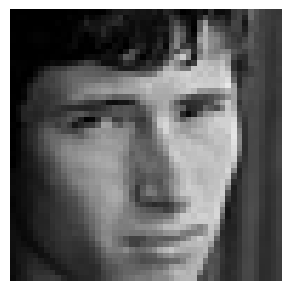

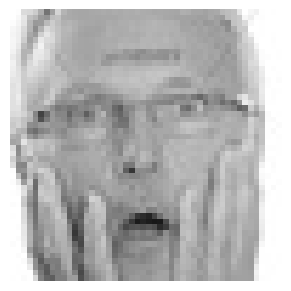

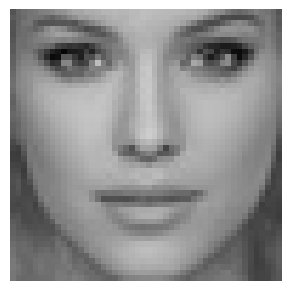

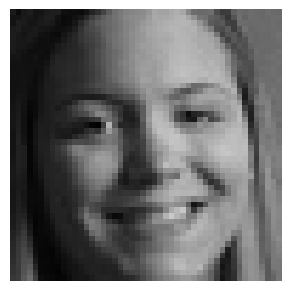

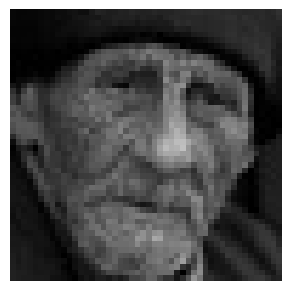

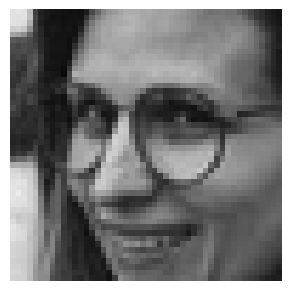

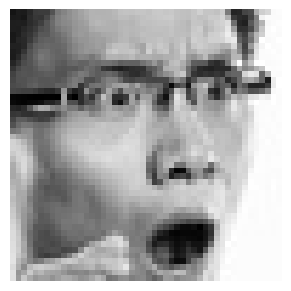

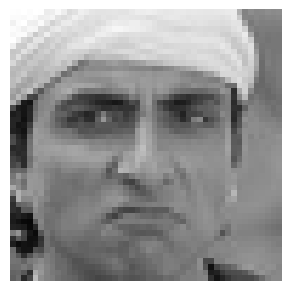

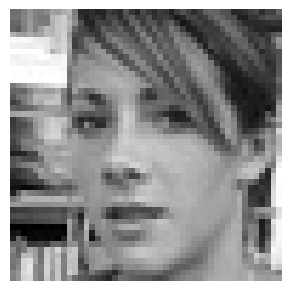

In [15]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [16]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**Defining Model**

In [17]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [18]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [19]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten,256)
    output  = Dense(7, activation="softmax")(dense_1)
    
#creates a Keras Model with the specified input and output tensors.
    model  =  Model(inputs=[inputs],outputs = [output])
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])
    return model
#The model is compiled with categorical crossentropy loss, the Adam optimizer, and accuracy as the evaluation metric.

In [20]:
model = model_fer((48,48,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

**Initialising the Model**

In [21]:
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#will save the model weights to "model_weights.h5" whenever there is an improvement in validation accuracy during training.
checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

# Training the Model

In [22]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/30
450/450 [==============================] - ETA: 0s - loss: 1.6893 - accuracy: 0.3573
Epoch 1: saving model to model_weights.h5
450/450 [==============================] - 98s 211ms/step - loss: 1.6893 - accuracy: 0.3573 - val_loss: 1.5304 - val_accuracy: 0.4115
Epoch 2/30
450/450 [==============================] - ETA: 0s - loss: 1.4068 - accuracy: 0.4608
Epoch 2: saving model to model_weights.h5
450/450 [==============================] - 77s 170ms/step - loss: 1.4068 - accuracy: 0.4608 - val_loss: 1.5079 - val_accuracy: 0.4151
Epoch 3/30
450/450 [==============================] - ETA: 0s - loss: 1.2856 - accuracy: 0.5131
Epoch 3: saving model to model_weights.h5
450/450 [==============================] - 73s 163ms/step - loss: 1.2856 - accuracy: 0.5131 - val_loss: 1.2553 - val_accuracy: 0.5216
Epoch 4/30
450/450 [==============================] - ETA: 0s - loss: 1.2130 - accuracy: 0.5427
Epoch 4: saving model to model_weights.h5
450/450 [==============================] - 85s

**Model Evaluation**

In [23]:
#code extracts the accuracy from the evaluation results.
model.evaluate(validation_generator)

111/111 [==============================] - 4s 39ms/step - loss: 1.3142 - accuracy: 0.5778


[1.3142448663711548, 0.5778375267982483]

**Plotting Loss**

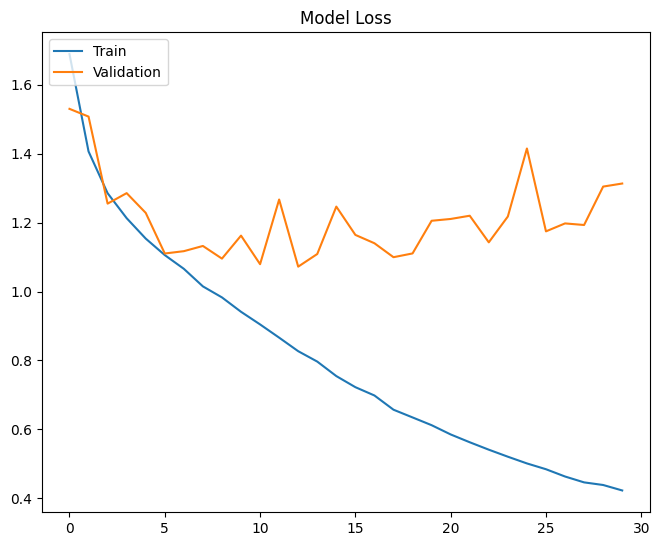

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

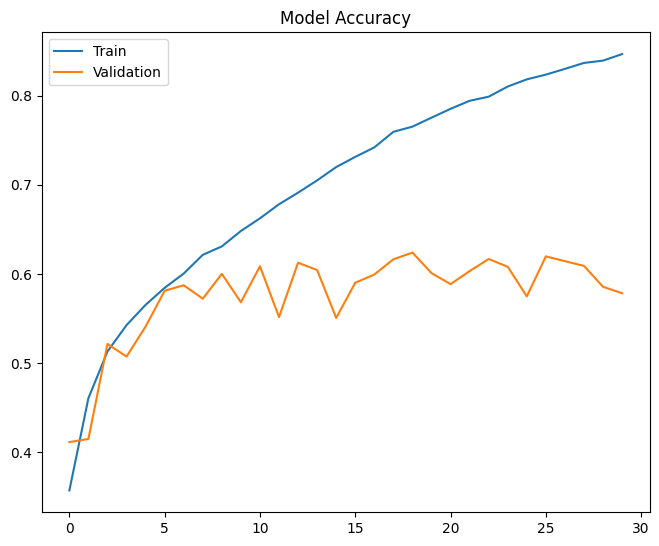

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [26]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)